In [1]:
import numpy as np
import tensorflow as tf
import torch
from torch import FloatTensor,Tensor,LongTensor
from DQNagent import DQNagent
import gym
import random
import matplotlib.pyplot as plt
import time

In [1]:
env = gym.make("CartPole-v1")
state = env.reset()[np.newaxis,:]
FloatTensor(state)

NameError: name 'gym' is not defined

# DQN
I have put the whole cartpole training into a function so it is easier to use. The parameters we have to tune are (in order of importance):
 - network_params. Most importantly the number of nodes as we can just asume that 'relu' activation is optimal
 - batch_size
 - learning_rate 
 - exploration_parameter
 - future_reward_discount_factor 
 - action_selection_method

When using a target network (target = True) the extra parameters to tune are:
 - target_network_update_frequency

When using experinece replay (buffer = True) the batch_size means something else so it has to, most likely, be retuned.

Non trainable parameters are:
 - target
 - buffer
 - total_episodes

In [2]:

def Cartpole(total_episodes,target, target_network_update_frequency, buffer, batch_size, learning_rate, future_reward_discount_factor,  hidden_dims, action_selection_method):
    
    EPSILON = 1.0
    MINIMUM_EPSILON = 0.0
    REWARD_TARGET = 500
    STEPS_TO_TAKE = REWARD_TARGET
    REWARD_INCREMENT = 1
    REWARD_THRESHOLD = 0
    EPSILON_DELTA = (EPSILON - MINIMUM_EPSILON)/STEPS_TO_TAKE
    
    scores = []
    env = gym.make("CartPole-v1")
    agent = DQNagent(env.observation_space.shape[0], env.action_space.n, target, buffer, batch_size, learning_rate, future_reward_discount_factor, hidden_dims)
    total_steps = 0
    for i in range(total_episodes):
        #reset the environment
        state = env.reset()

        
        #Cartpole-v1 has a maximum episode length of 500
        for t in range(500):
            env.render()
            #select action based on exploration method
            state = FloatTensor(state[np.newaxis,:])
            action = agent.action_selection(state, EPSILON, method = action_selection_method)
            
            #Get example, and save to replay buffer
            next_state, reward, done, _ = env.step(action)
            #if done: reward = -10 #Finishing before 500 steps means the cartpole fell, thus we give a -10 reward
            total_steps+=1

            agent.memorize(state, 
                 LongTensor([[action]]),
                 FloatTensor([reward]), 
                 FloatTensor(next_state[np.newaxis,:]), 
                 FloatTensor([done]))

            #Train network
            if len(agent.memory) >= batch_size:
                agent.train()

            #The score is how long the cart stayed upright, this can be a maximum of 500
            if done or t==499:
                print(f"Episode {i}: Score {t+1}/500")
                break
            if total_steps%target_network_update_frequency == 0 and target:
                agent.update_target_network()
            state = next_state
            if EPSILON > MINIMUM_EPSILON and t+1 >= REWARD_THRESHOLD:    
                EPSILON = EPSILON - EPSILON_DELTA    
                REWARD_THRESHOLD = REWARD_THRESHOLD + REWARD_INCREMENT
        scores.append(t+1)
    return scores

    

# Tuning Example
Here is an example where I try out 3 different learning rates $ = [0.1, 0.01, 0.001]$. Note that I am only doing $10$ episodes, this is way too little to remark anything, you would need at least 100. For this example however, I will use $10$ so that it goes quicker.

In [4]:
#Parameter I am optimizing
learning_rate = 1e-3

#Other optimizable parameters not being optimized now
future_reward_discount_factor = 1
hidden_dims = 16
action_selection_method = 'egreedy'
batch_size = 512 #While training it will take the last n=batch_size examples. If buffer=True then it will take n=batch_size random samples from the memory
target_network_update_frequency = 10 #After how many update steps do we update the target network

#Other parameters
buffer = True #If we want to include experience buffer to DQN
target = True #If we want to include target network to DQN
total_episodes = 500 #How many times the agent goes from reset -> done (note that after 500 steps the agent will return done no matter what so the training won't get stuck infinitely)

#The cartpole function returns a list of scores (per episode) so I will use this in a loop for all the learning rates
score = Cartpole(total_episodes,target, target_network_update_frequency, buffer, batch_size, learning_rate, future_reward_discount_factor, hidden_dims, action_selection_method)


Episode 0: Score 22/500
Episode 1: Score 58/500
Episode 2: Score 36/500
Episode 3: Score 33/500
Episode 4: Score 11/500
Episode 5: Score 16/500
Episode 6: Score 37/500
Episode 7: Score 22/500
Episode 8: Score 27/500
Episode 9: Score 29/500
Episode 10: Score 23/500
Episode 11: Score 14/500
Episode 12: Score 17/500
Episode 13: Score 14/500
Episode 14: Score 16/500
Episode 15: Score 15/500
Episode 16: Score 26/500
Episode 17: Score 62/500
Episode 18: Score 14/500
Episode 19: Score 43/500
Episode 20: Score 14/500
Episode 21: Score 35/500
Episode 22: Score 43/500
Episode 23: Score 10/500
Episode 24: Score 11/500
Episode 25: Score 14/500
Episode 26: Score 22/500
Episode 27: Score 29/500
Episode 28: Score 13/500
Episode 29: Score 11/500
Episode 30: Score 31/500
Episode 31: Score 10/500
Episode 32: Score 10/500
Episode 33: Score 16/500
Episode 34: Score 24/500
Episode 35: Score 64/500
Episode 36: Score 30/500
Episode 37: Score 21/500
Episode 38: Score 17/500
Episode 39: Score 35/500
Episode 40

KeyboardInterrupt: 

Text(0, 0.5, 'Score')

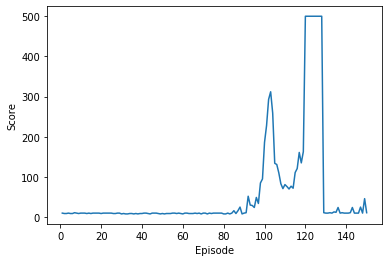

In [20]:

plt.plot(np.arange(1,total_episodes+1), score)
plt.xlabel("Episode")
plt.ylabel("Score")